In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\konec\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\konec\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [5]:
df = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['type', 'message'])

print(df.head())

   type                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [6]:
tokens = word_tokenize(df['message'][0])
print(tokens)

['Go', 'until', 'jurong', 'point', ',', 'crazy', '..', 'Available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', '...', 'Cine', 'there', 'got', 'amore', 'wat', '...']


Let´s find the proportion of message which are ham and spam

In [7]:
df.groupby('type').count()

,message
type,
ham,4825
spam,747


Text(0.5, 0, 'Type')

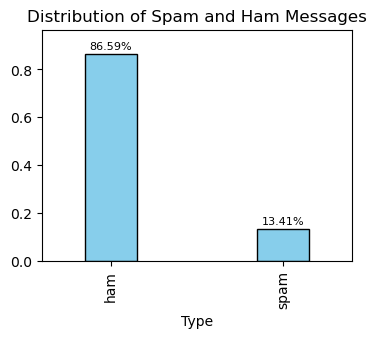

In [8]:
plt.figure(figsize=(4, 3))
proportion = df['type'].value_counts(normalize=True)
bars = proportion.plot(kind='bar', width=0.3, color='skyblue', edgecolor='black')
plt.ylim(0, proportion.max() + 0.1)
for i, value in enumerate(proportion):
    bars.text(i, value + 0.01, f'{value:.2%}', ha='center', va='bottom', fontsize=8)
plt.title('Distribution of Spam and Ham Messages')
plt.xlabel('Type')


In [9]:
# There's an umbalanced in the data, the ham messages are more common than spam.
# This is somenthing to take care at the moment of creating a model to predict future predictions in messages.
# Let's look for the most common messages by type or category.

In [10]:
df_ham_counts = df[df['type']=='ham'].groupby('message').aggregate(count=('message', 'size')).reset_index()
df_ham_counts = df_ham_counts.sort_values('count', ascending=False)
df_ham_counts.head(10)

,message,count
3327,"Sorry, I'll call later",30
1524,I cant pick the phone right now. Pls send a me...,12
2892,Ok...,10
62,7 wonders in My WORLD 7th You 6th Ur style 5th...,4
2920,Okie,4
2795,Ok,4
2872,Ok.,4
3144,"Say this slowly.? GOD,I LOVE YOU &amp; I NEED ...",4
3906,"Wen ur lovable bcums angry wid u, dnt take it ...",4
4342,Your opinion about me? 1. Over 2. Jada 3. Kusr...,4


In [11]:
df_spam_counts = df[df['type']=='spam'].groupby('message').aggregate(count=('message', 'size')).reset_index()
df_spam_counts = df_spam_counts.sort_values('count', ascending=False)
df_spam_counts.head(10)

,message,count
337,Please call our customer service representativ...,4
160,FREE for 1st week! No1 Nokia tone 4 ur mob eve...,3
284,"Loan for any purpose £500 - £75,000. Homeowner...",3
227,HMV BONUS SPECIAL 500 pounds of genuine HMV vo...,3
79,Camera - You are awarded a SiPix Digital Camer...,3
264,I don't know u and u don't know me. Send CHAT ...,3
13,18 days to Euro2004 kickoff! U will be kept in...,2
592,You have 1 new voicemail. Please call 08719181...,2
577,You are awarded a SiPix Digital Camera! call 0...,2
566,YOU ARE CHOSEN TO RECEIVE A £350 AWARD! Pls ca...,2


In [ ]:
# Now it'd be good to recognize patterns in the data like the length of the messages, with a general overview of the data 
# the spam messages seems to have a larger length.

In [ ]:
df_message_length = df.copy()
df_message_length['length'] = df_message_length['message'].apply(lambda x: len(x))


,type,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
5,spam,FreeMsg Hey there darling it's been 3 week's n...,147
6,ham,Even my brother is not like to speak with me. ...,77
7,ham,As per your request 'Melle Melle (Oru Minnamin...,160
8,spam,WINNER!! As a valued network customer you have...,157
9,spam,Had your mobile 11 months or more? U R entitle...,154


Text(0.5, 1.0, 'Length distribution of the spam messages')

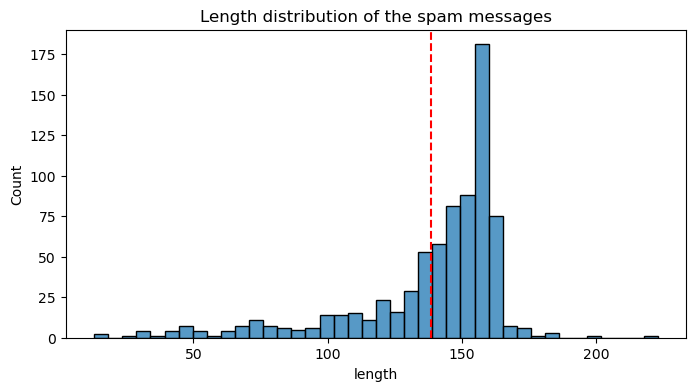

In [34]:
mean_length = df_message_length[df_message_length['type'] == 'spam']['length'].mean()
plt.figure(figsize=(8,4))
sns.histplot(df_message_length[df_message_length['type']=='spam']['length'])
plt.axvline(mean_length, color='red', linestyle='--', label='Mean Spam Length')
plt.title('Length distribution of the spam messages')